In [1]:
import os
print(os.environ.get("LD_PRELOAD"))
print(os.environ['PYOPENGL_PLATFORM'])
os.environ.pop("PYOPENGL_PLATFORM", None)

/usr/lib/x86_64-linux-gnu/libstdc++.so.6
osmesa


'osmesa'

In [2]:
import numpy as np
import trimesh
import pyrender
from pyrender.constants import RenderFlags

In [3]:
data = np.load('eval_data.npz', allow_pickle=True)
obj_v, obj_f = data['obj_vert'], data['obj_face']
lhand_v, lhand_f = data['lhand_vert'], data['lhand_face']
rhand_v, rhand_f = data['rhand_vert'], data['rhand_face']

In [4]:
def get_rotmat_x(radians=0):
    x_rotmat = np.array(
        [
            [1,                 0,                  0],
            [0,   np.cos(radians),   -np.sin(radians)],
            [0,   np.sin(radians),    np.cos(radians)]
        ]
    )
    return x_rotmat

def get_rotmat_y(radians=0):
    y_rotmat = np.array(
        [
            [ np.cos(radians),  0, np.sin(radians)],
            [               0,  1,               0],
            [-np.sin(radians),  0, np.cos(radians)]
        ]
    )
    return y_rotmat

def get_rotmat_z(radians=0):
    z_rotmat = np.array(
        [
            [np.cos(radians), -np.sin(radians), 0], 
            [np.sin(radians),  np.cos(radians), 0], 
            [                0,                  0, 1], 
        ]
    )
    return z_rotmat

In [ ]:
# 1. 准备模型数据（示例）

def render(t):
    # 2. 创建场景并添加网格
    scene = pyrender.Scene()

    # 3. 创建Trimesh对象
    mesh = trimesh.Trimesh(vertices=lhand_v[t], faces=lhand_f)
    # 4. 转换为PyRender网格
    mesh = pyrender.Mesh.from_trimesh(mesh)

    scene.add(mesh, name='lhand')

    mesh = trimesh.Trimesh(vertices=rhand_v[t], faces=rhand_f)
    mesh = pyrender.Mesh.from_trimesh(mesh)
    scene.add(mesh, name='rhand')

    for n in range(6):
        mesh = trimesh.Trimesh(vertices=obj_v[t,:,n], faces=obj_f[n])
        mesh = pyrender.Mesh.from_trimesh(mesh)
        scene.add(mesh, name=f'obj{n}')

    # 5. 设置相机（自动计算视角）
    camera = pyrender.PerspectiveCamera(yfov=1.15, znear=0.1, zfar=10, aspectRatio=1.0)
    s = np.sqrt(2)/2
    R = get_rotmat_x() @ get_rotmat_y() @ get_rotmat_z()
    T = np.array([0, 0, 0.5])[:,None]
    # camera_pose = np.array([
    #     [0.0, -s,   s,   0.3],  # 调整位置
    #     [1.0,  0.0, 0.0, .3],
    #     [0.0,  s,   s,   0.5],
    #     [0.0,  0.0, 0.0, 1.0]
    # ])
    camera_pose = np.concatenate(
        [np.concatenate([R, T], axis=-1), np.array([[0,0,0,1]])], axis=0
    )
    scene.add(camera, pose=camera_pose)

    # 6. 添加光源
    light = pyrender.DirectionalLight(color=[1.0, 1.0, 1.0], intensity=2.0)
    scene.add(light, pose=camera_pose)

    # 7. 离屏渲染
    renderer = pyrender.OffscreenRenderer(viewport_width=640, viewport_height=480)
    color, depth = renderer.render(scene, flags=RenderFlags.RGBA | RenderFlags.SHADOWS_DIRECTIONAL)

    # 8. 保存结果（可选）
    import imageio
    imageio.imwrite('render_output.png', color)
    imageio.imread()

    # 9. 清理资源
    renderer.delete()
    print(f"frame {t} done!!", end='\r')
    return color

In [6]:
ims = [render(t) for t in range(235)]

In [8]:
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation

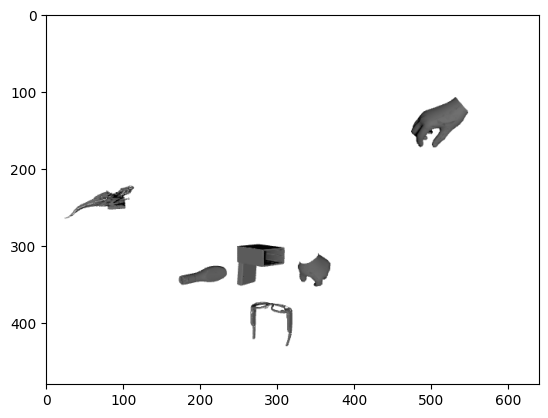

In [9]:
fig = plt.figure()
ax = fig.add_subplot()
im = ax.imshow(ims[0])

In [17]:
import imageio

imageio.mimwrite('vis.gif', ims)